# Project: NLP-based Text Similarity Detection

## Project Overview
This project aims to develop an NLP-based text similarity system that can automatically identify duplicate or highly similar documents 
## Methodology
1. **Data Collection**: Load dataset from Hugging Face.
2. **Preprocessing**: Tokenization, stopword removal, lemmatization.
3. **Feature Extraction**: TF-IDF vectorization and Cosine Similarity computation.
4. **Model Training**: Logistic Regression based on similarity scores.
5. **Evaluation**: Accuracy, Precision, Recall, F1-score, and Confusion Matrix.

In [7]:
!pip install pandas numpy scikit-learn nltk datasets matplotlib seaborn hf_xet huggingface_hub[hf_xet]

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from scipy.sparse import hstack
import string
import joblib

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\addis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\addis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\addis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\addis\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\addis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 2. Load Dataset
We will use the [`sentence-transformers/quora-duplicates`](https://huggingface.co/datasets/sentence-transformers/quora-duplicates) dataset (pair-class subset).

In [8]:
try:
    dataset = load_dataset("sentence-transformers/quora-duplicates", "pair-class")
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
df = pd.DataFrame(dataset['train'])

# Rename columns to match existing code
df = df.rename(columns={'sentence1': 'text1', 'sentence2': 'text2'})

# Using 10,000 samples to avoid memory error
# df = df.sample(n=10000, random_state=42)
# print(f"Dataset sampled to {len(df)} rows.")

print(f"Full dataset size: {len(df)} rows.")


print(df.head())
print(df.columns)

Dataset loaded successfully.
Full dataset size: 404290 rows.
                                               text1  \
0  What is the step by step guide to invest in sh...   
1  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2  How can I increase the speed of my internet co...   
3  Why am I mentally very lonely? How can I solve...   
4  Which one dissolve in water quikly sugar, salt...   

                                               text2  label  
0  What is the step by step guide to invest in sh...      0  
1  What would happen if the Indian government sto...      0  
2  How can Internet speed be increased by hacking...      0  
3  Find the remainder when [math]23^{24}[/math] i...      0  
4            Which fish would survive in salt water?      0  
Index(['text1', 'text2', 'label'], dtype='object')


## 3. Data Preprocessing
Cleaning the text data by tokenizing, removing stopwords, and lemmatizing.

In [9]:
from nltk.corpus import wordnet

  # Download necessary NLTK data (if not already downloaded)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('omw-1.4', quiet=True) # Open Multilingual Wordnet

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN # Default to Noun

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove Punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 3. Tokenize
    tokens = word_tokenize(text)
    
    # 4. Part-of-Speech Tagging
    pos_tags = nltk.pos_tag(tokens)
    
    # 5. Robust Lemmatization with POS Tags and Stopword Removal
    cleaned_tokens = []
    for word, tag in pos_tags:
        if word not in stop_words:
            # Use the POS tag to get the correct lemma (feature -> feature, featuring -> feature)
            lemma = lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag))
            cleaned_tokens.append(lemma)
            
    return " ".join(cleaned_tokens)


df['processed_1'] = df['text1'].apply(preprocess_text)
df['processed_2'] = df['text2'].apply(preprocess_text)

print(df[['processed_1', 'processed_2']].head())

                                         processed_1  \
0          step step guide invest share market india   
1                    story kohinoor kohinoor diamond   
2         increase speed internet connection use vpn   
3                              mentally lonely solve   
4  one dissolve water quikly sugar salt methane c...   

                                         processed_2  
0                step step guide invest share market  
1  would happen indian government steal kohinoor ...  
2                   internet speed increase hack dns  
3            find remainder math2324math divide 2423  
4                      fish would survive salt water  


## 4. Feature Extraction
We will compute the TF-IDF vectors for the documents and then calculate the Cosine Similarity between pairs.

In [10]:
# Use max_features to limit vocabulary size and avoid MemoryError
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

# Fit the vectorizer on all text data to ensure consistent vocabulary
all_text = pd.concat([df['processed_1'], df['processed_2']])
print(f"Fitting vectorizer on {len(all_text)} documents...")
tfidf_vectorizer.fit(all_text)

print("Transforming documents...")
tfidf_1 = tfidf_vectorizer.transform(df['processed_1'])
tfidf_2 = tfidf_vectorizer.transform(df['processed_2'])

# Create Additional Features
print("Creating feature matrix...")

# Feature 1: Cosine Similarity
cosine_scores = []
print("Computing cosine similarity...")
for i in range(tfidf_1.shape[0]):
    similarity = cosine_similarity(tfidf_1[i], tfidf_2[i])[0][0]
    cosine_scores.append(similarity)

df['cosine_similarity'] = cosine_scores

print(df[['cosine_similarity', 'label']].head())

Fitting vectorizer on 808580 documents...
Transforming documents...
Creating feature matrix...
Computing cosine similarity...
   cosine_similarity  label
0           0.978876      0
1           0.366186      0
2           0.577285      0
3           0.000000      0
4           0.413467      0


## 5. Model Training and Evaluation
We will use the Cosine Similarity score as a feature to train a Logistic Regression classifier.

Stacking features...
Final Feature Matrix Shape: (404290, 5001)
Target Label Distribution:
label
0    255027
1    149263
Name: count, dtype: int64


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished


Accuracy: 0.7523683494521259
Precision: 0.7508250618133234
Recall: 0.7523683494521259
F1-score: 0.7514775869191345

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.80     50803
           1       0.67      0.65      0.66     30055

    accuracy                           0.75     80858
   macro avg       0.73      0.73      0.73     80858
weighted avg       0.75      0.75      0.75     80858



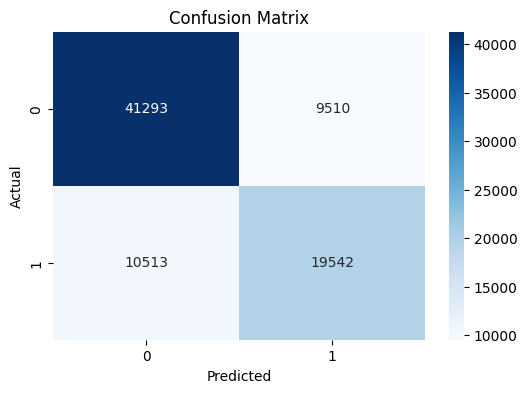

In [11]:
# Create rich feature set using Scipy Stack (Difference Vector + Standard Features)
import scipy.sparse

# 1. Feature Vectors: Difference between TF-IDF vectors (Sparse Matrix of shape N x 20000)
diff_vectors = abs(tfidf_1 - tfidf_2)

# 2. Scalar Features: Cosine Similarity (Dense Matrix of shape N x 1)
# We convert them to sparse format to stack efficiently with diff_vectors
scalar_features = df[['cosine_similarity']].values
scalar_features_sparse = scipy.sparse.csr_matrix(scalar_features)

# 3. Stack them horizontally
print("Stacking features...")
X = hstack([diff_vectors, scalar_features_sparse])
print(f"Final Feature Matrix Shape: {X.shape}")

y = df['label']

# Check if labels are continuous/float and convert to binary for classification
# If labels are similarity scores (0.0 to 1.0), we threshold at 0.5
if y.dtype == 'float' or y.dtype == 'float64' or y.dtype == 'float32':
    print("Labels appear to be continuous. Binarizing with threshold 0.5 to convert to classification task...")
    y = (y > 0.5).astype(int)

print("Target Label Distribution:")
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Increased max_iter to ensure convergence with many features
log_reg = LogisticRegression(max_iter=1000, verbose=1)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Save Model

In [12]:

joblib.dump(log_reg, "models/logistic_model.pkl")
joblib.dump(tfidf_vectorizer, "models/tfidf_vectorizer.pkl")


['models/tfidf_vectorizer.pkl']

## Conclusion
The Logistic Regression model was trained using Cosine Similarity scores derived from TF-IDF vectors of the document pairs. The evaluation metrics above demonstrate the performance of the system.